In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.environ['dir'] = "/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection"
%cd /content/gdrive/My Drive/AptosData/aptos2019-blindness-detection

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1VoIiqaGjfOUECGveuZ9M_wlPyn5DCNZd/AptosData/aptos2019-blindness-detection


In [2]:
#Pip install libraries needed
!pip install -U efficientnet
!pip install q tensorflow
!pip install q keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.1 MB/s eta 0:00:00


In [4]:
import os
from collections import defaultdict

splits = ['train', 'val', 'test']
counts = defaultdict(dict)

for split in splits:
    split_path = os.path.join('split_dataset', split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            counts[split][class_name] = num_images

# Print summary
for split in splits:
    print(f"\n📁 {split.upper()} set:")
    for cls, count in sorted(counts[split].items()):
        print(f"  {cls:16}: {count}")


📁 TRAIN set:
  Mild            : 259
  Moderate        : 699
  No_DR           : 1263
  Proliferate_DR  : 207
  Severe          : 135

📁 VAL set:
  Mild            : 55
  Moderate        : 150
  No_DR           : 271
  Proliferate_DR  : 44
  Severe          : 29

📁 TEST set:
  Mild            : 56
  Moderate        : 150
  No_DR           : 271
  Proliferate_DR  : 44
  Severe          : 29


# Features Extraction

In [3]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf

# Base model
base_model = EfficientNetB3(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.output)

# Setup
splits = ['train', 'val', 'test']
image_size = (224, 224)
batch_size = 32

for split in splits:
    print(f"\n🔄 Processing {split} set...")

    if split == 'train':
        datagen = ImageDataGenerator(
            preprocessing_function=preprocess_input,
            rotation_range=15,
            zoom_range=0.1,
            horizontal_flip=True,
            width_shift_range=0.1,
            height_shift_range=0.1
        )
    else:
        datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    generator = datagen.flow_from_directory(
        (f'split_dataset/{split}'),
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Extract bottleneck features
    features = model.predict(generator, verbose=1)
    print(f"✅ {split} features shape:", features.shape)

    # Get label array
    y = generator.classes
    if np.max(y) == 5:
        y = y - 1  # Normalize to 0–4 if needed

    # Save to disk
    np.save((f'5153_features_b3_{split}.npy'), features)
    np.save((f'5153_classes_b3_{split}.npy'), y)
    print(f"💾 Saved: {split} features and classes\n")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔄 Processing train set...
Found 2563 images belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 641s 8s/step
✅ train features shape: (2563, 1536)
💾 Saved: train features and classes


🔄 Processing val set...
Found 549 images belonging to 5 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step
✅ val features shape: (549, 1536)
💾 Saved: val features and classes


🔄 Processing test set...
Found 550 images belonging to 5 classes.
18/18 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step
✅ test features shape: (550, 1536)
💾 Saved: test features and classes



In [10]:
class_names = {
    0: "Mild",
    1: "Moderate",
    2: "No_DR",
    3: "Proliferate",
    4: "Severe"
}
target_names = [class_names[i] for i in sorted(class_names.keys())]

# Feature Extraction using EfficientNetB3 and Classify using Traditional Machine Learning Models


🔧 Training SVM...

📊 SVM Classification Report:

              precision    recall  f1-score   support

        mild     0.3028    0.6000    0.4024        55
    moderate     0.6517    0.3867    0.4854       150
        noDR     0.9359    0.9705    0.9529       271
      severe     0.3478    0.1818    0.2388        44
 proliferate     0.2128    0.3448    0.2632        29

    accuracy                         0.6776       549
   macro avg     0.4902    0.4968    0.4685       549
weighted avg     0.7095    0.6776    0.6763       549

📈 Cohen’s Kappa Score: 0.5226
ROC AUC Score (macro): 0.8881


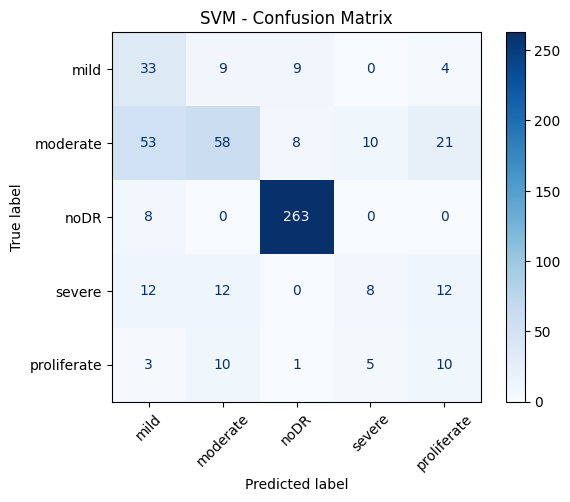


🔧 Training RandomForest...

📊 RandomForest Classification Report:

              precision    recall  f1-score   support

        mild     0.6000    0.0545    0.1000        55
    moderate     0.5388    0.8800    0.6684       150
        noDR     0.8796    0.9705    0.9228       271
      severe     0.0000    0.0000    0.0000        44
 proliferate     0.0000    0.0000    0.0000        29

    accuracy                         0.7250       549
   macro avg     0.4037    0.3810    0.3382       549
weighted avg     0.6415    0.7250    0.6481       549

📈 Cohen’s Kappa Score: 0.5479
ROC AUC Score (macro): 0.8629


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


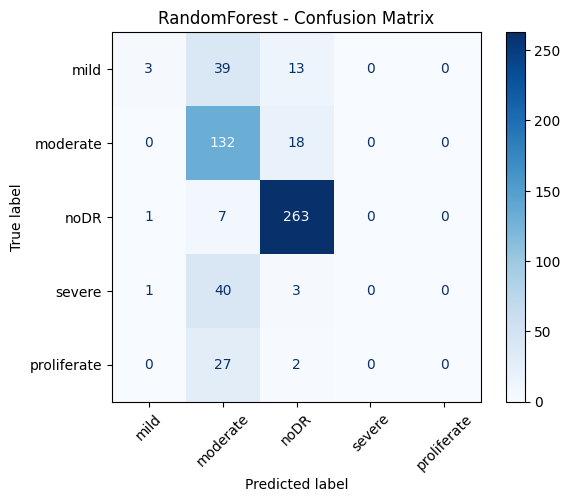


🔧 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:20:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



📊 XGBoost Classification Report:

              precision    recall  f1-score   support

        mild     0.4878    0.3636    0.4167        55
    moderate     0.5860    0.8400    0.6904       150
        noDR     0.9161    0.9668    0.9408       271
      severe     0.3333    0.0227    0.0426        44
 proliferate     0.5000    0.0690    0.1212        29

    accuracy                         0.7486       549
   macro avg     0.5647    0.4524    0.4423       549
weighted avg     0.7143    0.7486    0.7046       549

📈 Cohen’s Kappa Score: 0.5994
ROC AUC Score (macro): 0.8770


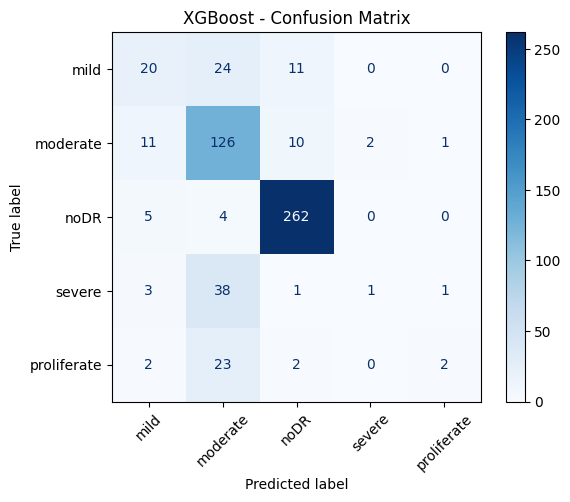


🧪 EVALUATION ON TEST SET

🔍 Testing SVM...

📊 SVM Classification Report (Test):

              precision    recall  f1-score   support

        mild     0.3585    0.6786    0.4691        56
    moderate     0.7500    0.3600    0.4865       150
        noDR     0.9296    0.9742    0.9514       271
      severe     0.5200    0.2955    0.3768        44
 proliferate     0.2698    0.5862    0.3696        29

    accuracy                         0.7018       550
   macro avg     0.5656    0.5789    0.5307       550
weighted avg     0.7549    0.7018    0.6988       550

📈 Cohen’s Kappa Score: 0.5619
🏅 ROC AUC Score (macro): 0.9002


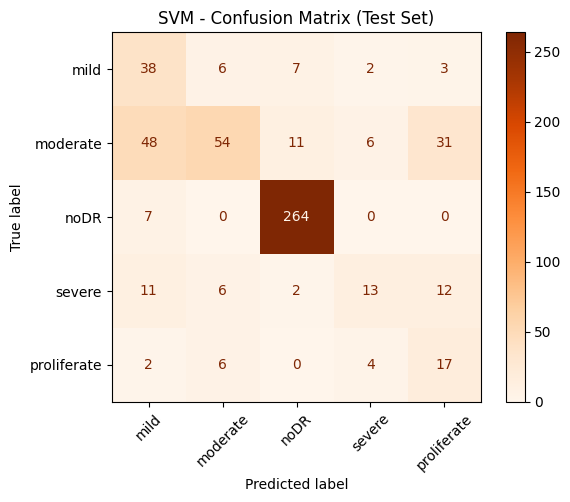


🔍 Testing RandomForest...

📊 RandomForest Classification Report (Test):

              precision    recall  f1-score   support

        mild     0.5000    0.0179    0.0345        56
    moderate     0.5244    0.8600    0.6515       150
        noDR     0.8771    0.9742    0.9231       271
      severe     0.0000    0.0000    0.0000        44
 proliferate     0.0000    0.0000    0.0000        29

    accuracy                         0.7164       550
   macro avg     0.3803    0.3704    0.3218       550
weighted avg     0.6261    0.7164    0.6360       550

📈 Cohen’s Kappa Score: 0.5334
🏅 ROC AUC Score (macro): 0.8791


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


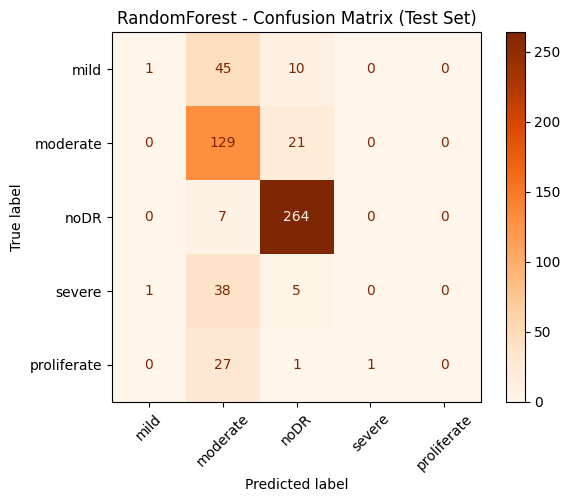


🔍 Testing XGBoost...

📊 XGBoost Classification Report (Test):

              precision    recall  f1-score   support

        mild     0.4727    0.4643    0.4685        56
    moderate     0.6096    0.7600    0.6766       150
        noDR     0.8949    0.9742    0.9329       271
      severe     0.5714    0.0909    0.1569        44
 proliferate     0.5000    0.1034    0.1714        29

    accuracy                         0.7473       550
   macro avg     0.6097    0.4786    0.4812       550
weighted avg     0.7274    0.7473    0.7134       550

📈 Cohen’s Kappa Score: 0.5996
🏅 ROC AUC Score (macro): 0.8899


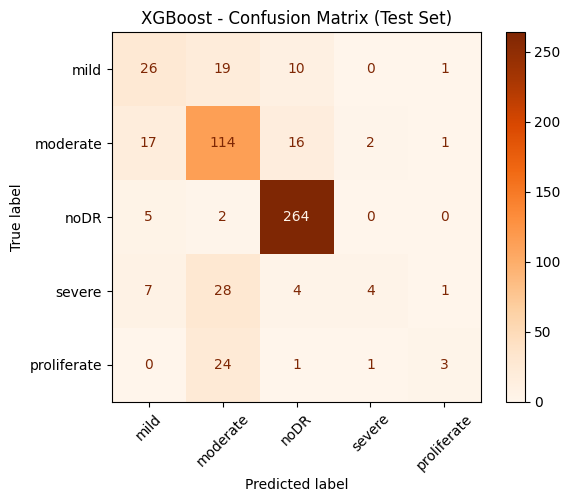

In [8]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay, cohen_kappa_score
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load features and labels
X_train = np.load('5153_features_b3_train.npy')
y_train = np.load('5153_classes_b3_train.npy')

X_val = np.load('5153_features_b3_val.npy')
y_val = np.load('5153_classes_b3_val.npy')

# Define class names
class_names = ['mild', 'moderate', 'noDR', 'severe', 'proliferate']

# Binarize labels for ROC AUC
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4])

# Models
models = {
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6
    )
}

for name, model in models.items():
    print(f"\n🔧 Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # If supported, get probabilities for ROC AUC
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)
    else:
        y_proba = model.decision_function(X_val)

    # Classification report
    print(f"\n📊 {name} Classification Report:\n")
    print(classification_report(y_val, y_pred, target_names=class_names, digits=4))

    # Kappa Score
    print(f"📈 Cohen’s Kappa Score: {cohen_kappa_score(y_val, y_pred):.4f}")

    # ROC AUC
    try:
        roc_auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')
        print(f"ROC AUC Score (macro): {roc_auc:.4f}")
    except Exception as e:
        print(f"Could not compute ROC AUC: {e}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.xticks(rotation=45)
    plt.show()


  # Load test set
X_test = np.load('5153_features_b3_test.npy')
y_test = np.load('5153_classes_b3_test.npy')
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

print("\n======================")
print("🧪 EVALUATION ON TEST SET")
print("======================")

for name, model in models.items():
    print(f"\n🔍 Testing {name}...")

    y_pred = model.predict(X_test)

    # If supported, get probabilities
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        y_proba = model.decision_function(X_test)

    # Classification report
    print(f"\n📊 {name} Classification Report (Test):\n")
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    # Kappa Score
    print(f"📈 Cohen’s Kappa Score: {cohen_kappa_score(y_test, y_pred):.4f}")

    # ROC AUC
    try:
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
        print(f"🏅 ROC AUC Score (macro): {roc_auc:.4f}")
    except Exception as e:
        print(f"⚠️ Could not compute ROC AUC: {e}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Oranges)
    plt.title(f"{name} - Confusion Matrix (Test Set)")
    plt.xticks(rotation=45)
    plt.show()



# Feature Extraction using EfficientNetB3 and Classify using Traditional Machine Learning Models with SMOTE

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:00:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


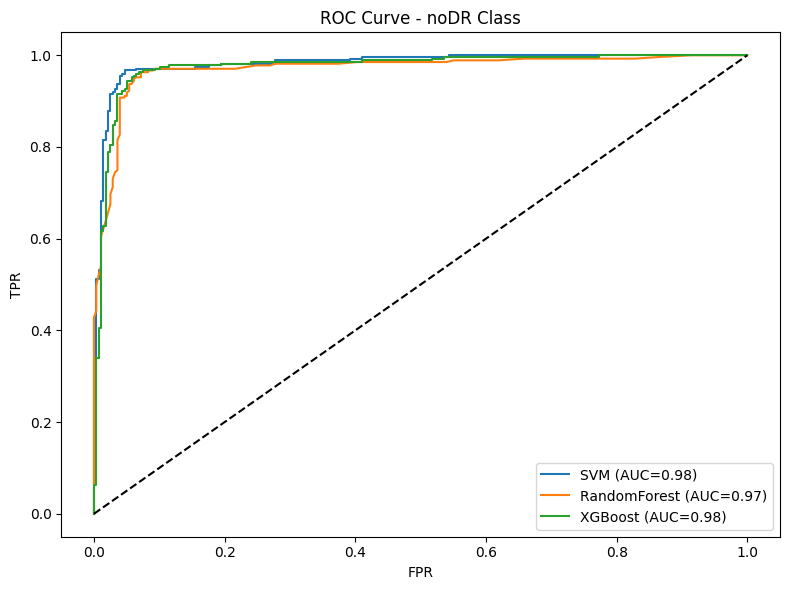

          Model  Accuracy  F1_macro     Kappa  ROC_AUC_macro
0           SVM  0.734062  0.512422  0.594586       0.886314
1  RandomForest  0.726776  0.463555  0.570893       0.870281
2       XGBoost  0.735883  0.476826  0.586087       0.877756


In [3]:
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd

# Load data
X_train = np.load('5153_features_b3_train.npy')
y_train = np.load('5153_classes_b3_train.npy')
X_val = np.load('5153_features_b3_val.npy')
y_val = np.load('5153_classes_b3_val.npy')

# Apply SMOTE+ENN

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)


# Models
models = {
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6
    )
}

results = {}
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4])
class_names = ['mild', 'moderate', 'noDR', 'severe', 'proliferate']
n_classes = len(class_names)

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)
    results[name] = (y_pred, y_proba)

# ROC plot (noDR class)
plt.figure(figsize=(8, 6))
for name, (y_pred, y_proba) in results.items():
    fpr, tpr, _ = roc_curve(y_val_bin[:, 2], y_proba[:, 2])  # class 2 = noDR
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - noDR Class')
plt.legend()
plt.tight_layout()
plt.show()

# Performance summary
summary = []
for name, (y_pred, y_proba) in results.items():
    summary.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "F1_macro": classification_report(y_val, y_pred, output_dict=True)['macro avg']['f1-score'],
        "Kappa": cohen_kappa_score(y_val, y_pred),
        "ROC_AUC_macro": roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')
    })
print(pd.DataFrame(summary))




/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:02:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


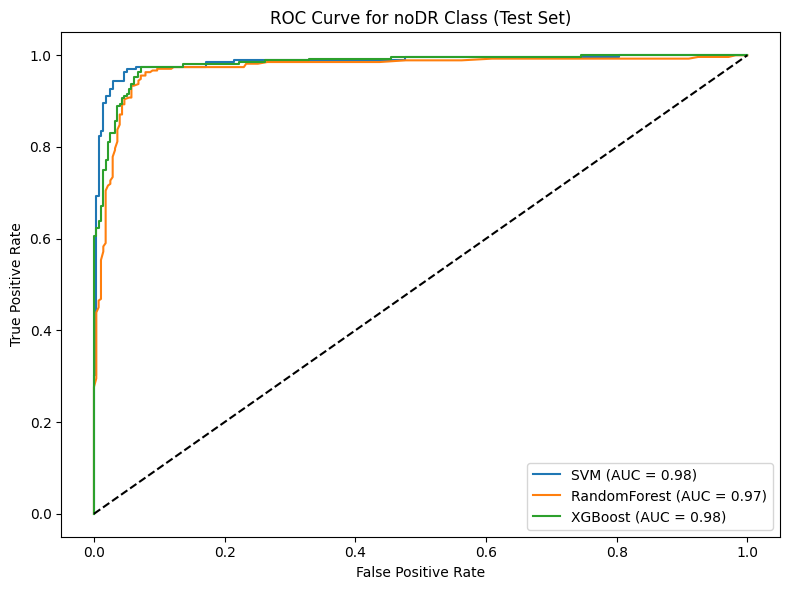


📊 Test Set Performance Summary:
          Model  Accuracy  F1_macro     Kappa  ROC_AUC_macro
0           SVM  0.747273  0.566302  0.616328       0.900555
1  RandomForest  0.732727  0.490256  0.579679       0.881782
2       XGBoost  0.763636  0.552533  0.632065       0.896450


In [6]:
import numpy as np
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score, cohen_kappa_score,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import pandas as pd

# Load test data
X_test = np.load('5153_features_b3_test.npy')
y_test = np.load('5153_classes_b3_test.npy')
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
class_names = ['mild', 'moderate', 'noDR', 'severe', 'proliferate']
n_classes = len(class_names)

# Load trained models
from joblib import load
# If you saved models: svm_model = load("svm_model.joblib"), etc.
# Otherwise reuse: svm_model, rf_model, xgb_model from earlier code

# Evaluate models
results_test = {}
models = {
    "SVM": SVC(kernel='rbf', class_weight='balanced', probability=True),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6
    )
}

for name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    results_test[name] = (y_pred, y_proba)

# Plot ROC for noDR class
plt.figure(figsize=(8, 6))
for name, (y_pred, y_proba) in results_test.items():
    fpr, tpr, _ = roc_curve(y_test_bin[:, 2], y_proba[:, 2])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for noDR Class (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Summary table
summary_test = []
for name, (y_pred, y_proba) in results_test.items():
    summary_test.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1_macro": classification_report(y_test, y_pred, output_dict=True)['macro avg']['f1-score'],
        "Kappa": cohen_kappa_score(y_test, y_pred),
        "ROC_AUC_macro": roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    })

print("\n📊 Test Set Performance Summary:")
print(pd.DataFrame(summary_test))


# Feature Extraction using EfficientNet and DenseNet + Feature Selection using Gray Wolf Optimizer

In [4]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.applications import EfficientNetB0, DenseNet121
from keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from keras.applications.densenet import preprocess_input as preprocess_densenet
from keras.preprocessing.image import load_img, img_to_array

# ==== Paths ====
BASE_DIR = "/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection"
SPLIT_ROOT = os.path.join(BASE_DIR, "split_dataset")


# ==== Alphabetical label map ====
LABELS_ALPHABETICAL = sorted(["Mild", "Moderate", "No_DR", "Proliferate_DR", "Severe"])
label_map = {name: idx for idx, name in enumerate(LABELS_ALPHABETICAL)}


# ==== Load models once ====
IMG_SIZE = 224
eff_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))
dns_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_SIZE, IMG_SIZE, 3))

# ==== Feature Extraction Function ====
def extract_features_with_labels(image_root, label_map, split_name):
    all_features, labels, ids = [], [], []

    for class_name in os.listdir(image_root):
        class_path = os.path.join(image_root, class_name)
        if not os.path.isdir(class_path):
            continue
        label = label_map.get(class_name)
        if label is None:
            print(f"⚠️ Unknown label: {class_name}, skipping...")
            continue

        for fname in tqdm(os.listdir(class_path), desc=f"{split_name}/{class_name}"):
            if not fname.endswith(".png"):
                continue
            fpath = os.path.join(class_path, fname)
            img = load_img(fpath, target_size=(IMG_SIZE, IMG_SIZE))
            arr = img_to_array(img)
            arr = np.expand_dims(arr, axis=0)

            eff_input = preprocess_efficientnet(arr.copy())
            dns_input = preprocess_densenet(arr.copy())

            eff_feat = eff_model.predict(eff_input, verbose=0)[0]
            dns_feat = dns_model.predict(dns_input, verbose=0)[0]

            combined = np.concatenate([eff_feat, dns_feat])
            all_features.append(combined)
            labels.append(label)
            ids.append(fname.replace(".png", ""))

    return np.array(all_features), labels, ids

# ==== Loop through all splits ====
for split_name in ["train", "val", "test"]:
    print(f"\n🔁 Processing split: {split_name}")
    split_path = os.path.join(SPLIT_ROOT, split_name)
    features, labels, ids = extract_features_with_labels(split_path, label_map, split_name)

    # Save to CSV
    df = pd.DataFrame(features)
    df["label"] = labels
    df["id_code"] = ids
    save_path = os.path.join(BASE_DIR, f"{split_name}_features.csv")
    df.to_csv(save_path, index=False)
    print(f"✅ Saved {split_name} features to {save_path}")


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔁 Processing split: train


train/Proliferate_DR: 100%|██████████| 207/207 [00:39<00:00,  5.29it/s]


✅ Saved train features to /content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/train_features.csv

🔁 Processing split: val


val/Severe: 100%|██████████| 29/29 [00:12<00:00,  2.38it/s]


✅ Saved val features to /content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/val_features.csv

🔁 Processing split: test


test/Severe: 100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


✅ Saved test features to /content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/test_features.csv


In [6]:
!pip install mealpy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 124.7 MB/s eta 0:00:00


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from mealpy.swarm_based import GWO
from mealpy.utils.problem import Problem
from mealpy.utils.space import BinaryVar

# === Load train features ===
train_df = pd.read_csv("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/train_features.csv")
X = train_df.drop(columns=["label", "id_code"]).values
y = train_df["label"].values

# === Standardize ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Fitness Function: Stratified KFold + Kappa + Feature Count Penalty ===
def fitness(solution):
    idx = np.where(solution > 0.5)[0]
    num_features = len(idx)

    if num_features == 0:
        return 1.0  # Heavily penalize no features

    X_sub = X_scaled[:, idx]
    clf = SVC(kernel="rbf", class_weight="balanced", random_state=42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    kappas = []

    for train_idx, val_idx in skf.split(X_sub, y):
        X_train, X_val = X_sub[train_idx], X_sub[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        kappas.append(cohen_kappa_score(y_val, preds))

    avg_kappa = np.mean(kappas)

    # === Add feature penalty ===
    feature_penalty = num_features / dim  # Smaller is better
    total_score = (1 - avg_kappa) + 0.2 * feature_penalty

    return total_score


# === Define GWO Problem ===
dim = X_scaled.shape[1]
bounds = [BinaryVar() for _ in range(dim)]

problem = Problem(
    obj_func=fitness,
    bounds=bounds,
    minmax="min",
    name="WrapperFeatureSelection_GWO"
)

# === Run GWO ===
model = GWO.OriginalGWO(epoch=10, pop_size=20)
best = model.solve(problem)

# === Save selected feature indices ===
selected_idx = np.where(best.solution > 0.5)[0]
np.save("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/selected_features_idx.npy", selected_idx)
print(f"✅ Selected {len(selected_idx)} features out of {dim}")


INFO:mealpy.swarm_based.GWO.OriginalGWO:Solving single objective optimization problem.
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: WrapperFeatureSelection_GWO, Epoch: 1, Current best: 0.40088114810131525, Global best: 0.40088114810131525, Runtime: 186.00579 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: WrapperFeatureSelection_GWO, Epoch: 2, Current best: 0.40088114810131525, Global best: 0.40088114810131525, Runtime: 181.20156 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: WrapperFeatureSelection_GWO, Epoch: 3, Current best: 0.39930170110284846, Global best: 0.39930170110284846, Runtime: 179.64669 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: WrapperFeatureSelection_GWO, Epoch: 4, Current best: 0.3985867092415263, Global best: 0.3985867092415263, Runtime: 174.09479 seconds
INFO:mealpy.swarm_based.GWO.OriginalGWO:>>>Problem: WrapperFeatureSelection_GWO, Epoch: 5, Current best: 0.3977776125468315, Global best: 0.3977776125468315, Runtime: 

✅ Selected 987 features out of 2304


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# === Load validation set ===
val_df = pd.read_csv("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/val_features.csv")
selected_idx = np.load("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/selected_features_idx.npy")
X_val = val_df.drop(columns=["label", "id_code"]).values[:, selected_idx]
y_val = val_df["label"].values

# === Refit StandardScaler using training data ===
X_train = train_df.drop(columns=["label", "id_code"]).values[:, selected_idx]
y_train = train_df["label"].values
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)

# === SVM Hyperparameter Tuning ===
param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001]
}
grid = GridSearchCV(SVC(kernel="rbf", class_weight="balanced", probability=True), param_grid, cv=5, scoring="balanced_accuracy", verbose=1)
grid.fit(X_train_std, y_train)

print("✅ Best Parameters:", grid.best_params_)

# === Evaluate Best Model ===
from sklearn.metrics import classification_report, cohen_kappa_score

best_model = grid.best_estimator_
preds = best_model.predict(X_val_std)

print("\n📊 Evaluation on Validation Set:")
print("Cohen's Kappa:", cohen_kappa_score(y_val, preds))
print(classification_report(y_val, preds))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
✅ Best Parameters: {'C': 1, 'gamma': 0.001}

📊 Evaluation on Validation Set:
Cohen's Kappa: 0.6851921713018153
              precision    recall  f1-score   support

           0       0.55      0.65      0.60        55
           1       0.75      0.71      0.73       150
           2       0.94      0.96      0.95       271
           3       0.60      0.48      0.53        44
           4       0.38      0.38      0.38        29

    accuracy                           0.79       549
   macro avg       0.64      0.64      0.64       549
weighted avg       0.79      0.79      0.79       549



In [12]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Binarize the labels for ROC AUC
y_val_bin = label_binarize(y_val, classes=[0, 1, 2, 3, 4])  # assuming labels are 0–4

# Get probability predictions
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_val_std)

    # Calculate macro-average ROC AUC
    roc_auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')
    print("🏅 ROC AUC (macro):", round(roc_auc, 4))
else:
    print("⚠️ Model does not support probability output (make sure probability=True in SVC).")


🏅 ROC AUC (macro): 0.9236


In [13]:
# === Load Test Set ===
test_df = pd.read_csv("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/test_features.csv")
X_test = test_df.drop(columns=["label", "id_code"]).values[:, selected_idx]
y_test = test_df["label"].values

# === Standardize Test Data ===
X_test_std = scaler.transform(X_test)

# === Predict on Test Set ===
y_pred_test = best_model.predict(X_test_std)

# === Classification Report & Kappa ===
from sklearn.metrics import classification_report, cohen_kappa_score, roc_auc_score
from sklearn.preprocessing import label_binarize

print("\n📊 Evaluation on Test Set:")
print("Cohen's Kappa:", cohen_kappa_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# === ROC AUC ===
# Binarize true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

# Get predicted probabilities
if hasattr(best_model, "predict_proba"):
    y_proba_test = best_model.predict_proba(X_test_std)

    roc_auc = roc_auc_score(y_test_bin, y_proba_test, average='macro', multi_class='ovr')
    print("🏅 ROC AUC Score (macro):", round(roc_auc, 4))
else:
    print("⚠️ Model does not support predict_proba(). Ensure SVC was initialized with probability=True.")


📊 Evaluation on Test Set:
Cohen's Kappa: 0.6930069372458336
              precision    recall  f1-score   support

           0       0.61      0.70      0.65        56
           1       0.78      0.66      0.71       150
           2       0.94      0.97      0.95       271
           3       0.59      0.50      0.54        44
           4       0.35      0.48      0.41        29

    accuracy                           0.80       550
   macro avg       0.65      0.66      0.65       550
weighted avg       0.80      0.80      0.80       550

🏅 ROC AUC Score (macro): 0.9265


In [14]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, cohen_kappa_score, accuracy_score

# === Load selected feature indices and data ===
selected_idx = np.load("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/selected_features_idx.npy")

train_df = pd.read_csv("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/train_features.csv")
val_df = pd.read_csv("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/val_features.csv")

X_train = train_df.drop(columns=["label", "id_code"]).values[:, selected_idx]
y_train = train_df["label"].values

X_val = val_df.drop(columns=["label", "id_code"]).values[:, selected_idx]
y_val = val_df["label"].values

# === Standardize features (optional for tree-based models, but consistent) ===
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_val_std = scaler.transform(X_val)


rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_val)
print("Cohen's Kappa:", cohen_kappa_score(y_val, rf_preds))
print(classification_report(y_val, rf_preds))


xgb_grid = XGBClassifier(
        objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        use_label_encoder=False,
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6
    )
xgb_grid.fit(X_train, y_train)
xgb_preds = xgb_grid.predict(X_val)
print("Cohen's Kappa:", cohen_kappa_score(y_val, xgb_preds))
print(classification_report(y_val, xgb_preds))

Cohen's Kappa: 0.6144866474482846
              precision    recall  f1-score   support

           0       0.58      0.33      0.42        55
           1       0.58      0.86      0.69       150
           2       0.93      0.97      0.95       271
           3       1.00      0.07      0.13        44
           4       0.40      0.14      0.21        29

    accuracy                           0.76       549
   macro avg       0.70      0.47      0.48       549
weighted avg       0.78      0.76      0.72       549



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:42:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Cohen's Kappa: 0.6797783529583318
              precision    recall  f1-score   support

           0       0.63      0.47      0.54        55
           1       0.66      0.86      0.75       150
           2       0.93      0.97      0.95       271
           3       0.77      0.23      0.35        44
           4       0.56      0.31      0.40        29

    accuracy                           0.80       549
   macro avg       0.71      0.57      0.60       549
weighted avg       0.79      0.80      0.78       549



In [15]:
# === Load Test Set ===
test_df = pd.read_csv("/content/gdrive/My Drive/AptosData/aptos2019-blindness-detection/test_features.csv")
X_test = test_df.drop(columns=["label", "id_code"]).values[:, selected_idx]
y_test = test_df["label"].values

# === Standardize Test Data (only if you standardized train) ===
X_test_std = scaler.transform(X_test)

# === Evaluate Random Forest ===
rf_test_preds = rf.predict(X_test)
print("\n🌲 Random Forest - Test Set Evaluation")
print("Cohen's Kappa:", cohen_kappa_score(y_test, rf_test_preds))
print(classification_report(y_test, rf_test_preds))

# === Evaluate XGBoost ===
xgb_test_preds = xgb_grid.predict(X_test)
print("\n🚀 XGBoost - Test Set Evaluation")
print("Cohen's Kappa:", cohen_kappa_score(y_test, xgb_test_preds))
print(classification_report(y_test, xgb_test_preds))


🌲 Random Forest - Test Set Evaluation
Cohen's Kappa: 0.6424039681624178
              precision    recall  f1-score   support

           0       0.68      0.45      0.54        56
           1       0.61      0.87      0.72       150
           2       0.93      0.97      0.95       271
           3       0.50      0.07      0.12        44
           4       0.38      0.10      0.16        29

    accuracy                           0.77       550
   macro avg       0.62      0.49      0.50       550
weighted avg       0.75      0.77      0.74       550


🚀 XGBoost - Test Set Evaluation
Cohen's Kappa: 0.678904296431007
              precision    recall  f1-score   support

           0       0.68      0.54      0.60        56
           1       0.65      0.83      0.73       150
           2       0.94      0.97      0.95       271
           3       0.64      0.32      0.42        44
           4       0.40      0.14      0.21        29

    accuracy                           0.79   

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# === Binarize labels (for ROC AUC) ===
classes = [0, 1, 2, 3, 4]
y_val_bin = label_binarize(y_val, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)

# === Predict probabilities for ROC AUC ===
rf_val_proba = rf.predict_proba(X_val)
rf_test_proba = rf.predict_proba(X_test)

xgb_val_proba = xgb_grid.predict_proba(X_val)
xgb_test_proba = xgb_grid.predict_proba(X_test)

# === ROC AUC (macro) ===
print("📊 ROC AUC Scores (macro):\n")

print(f"🌲 Random Forest - Validation ROC AUC: {roc_auc_score(y_val_bin, rf_val_proba, average='macro', multi_class='ovr'):.4f}")
print(f"🌲 Random Forest - Test ROC AUC:       {roc_auc_score(y_test_bin, rf_test_proba, average='macro', multi_class='ovr'):.4f}")

print(f"🚀 XGBoost - Validation ROC AUC:      {roc_auc_score(y_val_bin, xgb_val_proba, average='macro', multi_class='ovr'):.4f}")
print(f"🚀 XGBoost - Test ROC AUC:            {roc_auc_score(y_test_bin, xgb_test_proba, average='macro', multi_class='ovr'):.4f}")


📊 ROC AUC Scores (macro):

🌲 Random Forest - Validation ROC AUC: 0.9036
🌲 Random Forest - Test ROC AUC:       0.9074
🚀 XGBoost - Validation ROC AUC:      0.9163
🚀 XGBoost - Test ROC AUC:            0.9122
